### Multi label classification example

This notebook will demonstrate how to use BERT to perform multilabel classification via transfer learning.

It is using a Twitter (now X) dataset from kaggle which has binary labels for 11 different emotions.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_text as text

from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

import pandas as pd
from sklearn.model_selection import train_test_split

C:\Users\deaga\anaconda3\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (3.0.4)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [3]:
train_df = pd.read_csv('datasets/E-c-En-train.csv')
test_df = pd.read_csv('datasets/E-c-En-dev.csv')

train_df.shape

(6838, 13)

In [4]:
train_df.drop('ID',axis=1, inplace=True)
test_df.drop('ID',axis=1, inplace=True)
train_df

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6833,@nicky57672 Hi! We are working towards your hi...,0,0,0,0,0,0,0,0,0,0,0
6834,@andreamitchell said @berniesanders not only d...,0,1,0,0,0,0,0,0,0,1,0
6835,@isthataspider @dhodgs i will fight this guy! ...,1,0,1,0,0,0,0,1,0,0,0
6836,i wonder how a guy can broke his penis while h...,0,0,0,0,0,0,0,0,0,1,0


In [5]:
test_df.columns

Index(['Tweet', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust'],
      dtype='object')

### Text preprocessing

In [6]:
import re
import emoji

In [7]:
# Function for converting emojis into words
def convert_emojis(text):
    text = emoji.demojize(text)
    return text

In [8]:
train_df['Tweet'] = train_df['Tweet'].map(lambda x : convert_emojis(x))
test_df['Tweet'] = test_df['Tweet'].map(lambda x : convert_emojis(x))

In [9]:
def clean_text(text):
    #converts to lower case
    text = text.lower()
    #remove tags
    text = re.sub('\S*@\S*', ' ', text)
    #remove contractions and remove space
    text = re.sub('\'', '', text)
    #remove all special characters except for ? and !
    text = re.sub('[^A-Za-z!?]', ' ', text)
    # removes numbers
    text = re.sub('\w*\d\w*', ' ', text) 
    # substitutes _ with a space
    text = re.sub('_', ' ', text)
    # Substituting multiple spaces with single space
    text = re.sub('\s+', ' ', text)
    #removes blank space at start of text
    text = text.strip(' ') 
    return text

In [10]:
clean_text('\/# ?? !! @word blah blah\'s')

'?? !! blah blahs'

In [11]:
train_df['Tweet'] = train_df['Tweet'].map(lambda x : clean_text(x))
test_df['Tweet'] = test_df['Tweet'].map(lambda x : clean_text(x))

In [12]:
train_df['Tweet'][:20].to_list()

['worry is a down payment on a problem you may never have joyce meyer motivation leadership worry',
 'whatever you decide to do make sure it makes you happy',
 'it also helps that the majority of nfl coaching is inept some of bill obriens play calling was wow ! gopats',
 'accept the challenges so that you can literally even feel the exhilaration of victory george s patton dog face',
 'my roommate its okay that we cant spell because we have autocorrect terrible firstworldprobs',
 'no but thats so cute atsu was probably shy about photos before but cherry helped her out uwu',
 'do you think humans have the sense for recognizing impending doom?',
 'rooneys fucking untouchable isnt he? been fucking dreadful again depay has looked decent ish tonight',
 'its pretty depressing when u hit pan on ur favourite highlighter',
 'but your pussy was weak from what i heard so stfu up to me bitch you got to threaten him that your pregnant',
 'making that yearly transition from excited and hopeful colleg

### Loading the BERT model

In [13]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12_4'

map_name_to_handle = {'bert_en_uncased_L-12_H-768_A-12_4': "bert_uncased"}

map_model_to_preprocess = {'bert_en_uncased_L-12_H-768_A-12_4': "preprocess"}

In [14]:
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

#### Example of encoded message

In [15]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant([train_df['Tweet'][0]]))
print(tok)

<tf.RaggedTensor [[[4737],
  [2003],
  [1037],
  [2091],
  [7909],
  [2006],
  [1037],
  [3291],
  [2017],
  [2089],
  [2196],
  [2031],
  [11830],
  [11527],
  [14354],
  [4105],
  [4737]]]>


#### Defining the model architecture

In [16]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    # using the pooled_output as this is a classification process
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.4)(net)
    # adding some additional fully connected layers
    net = tf.keras.layers.Dense(768)(net)
    net = tf.keras.layers.Dropout(0.4)(net)
    net = tf.keras.layers.Dense(384)(net)
    net = tf.keras.layers.Dropout(0.4)(net)
    # Using a relevant output layer suited to the classificatin type - 11 binary classes
    net = tf.keras.layers.Dense(11, activation='sigmoid', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [17]:
classifier_model = build_classifier_model()

Preparing train and test evaluation sets

In [18]:
train_x = train_df['Tweet']
train_y = train_df.loc[:,['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values

test_x = test_df['Tweet']
test_y = test_df.loc[:,['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values

In [19]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((6838,), (6838, 11), (886,), (886, 11))

In [20]:
train_x

0       worry is a down payment on a problem you may n...
1       whatever you decide to do make sure it makes y...
2       it also helps that the majority of nfl coachin...
3       accept the challenges so that you can literall...
4       my roommate its okay that we cant spell becaus...
                              ...                        
6833    hi! we are working towards your highlighted co...
6834    said not only did not play up hrc in campaigni...
6835    i will fight this guy! dont insult the lions l...
6836    i wonder how a guy can broke his penis while h...
6837        im highly animated even though im decomposing
Name: Tweet, Length: 6838, dtype: object

### Model Training

In [21]:
tf.keras.backend.clear_session()

classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [22]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [23]:
epochs = 5
batch_size = 32

In [24]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score 

class MultiLabelF1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        val_x, val_y = self.validation_data

        # Run inference in "no_grad" mode to speed it up
        y_pred = self.model.predict(val_x, verbose=0)
        y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

        # Compute F1-score for multi-label classification
        f1 = f1_score(val_y, y_pred, average="samples", zero_division=1)  # "samples" is best for multi-label tasks

        logs["val_f1_score"] = f1
#         print(f" — val_f1_score: {f1:.4f}")

# Train model with optimized callback
f1_callback = MultiLabelF1ScoreCallback(validation_data=(test_x, test_y))

history = classifier_model.fit(
    train_x,
    train_y,
    validation_data=(test_x, test_y),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[f1_callback]
)

Epoch 1/5
214/214 [==============================] - 75s 304ms/step - loss: 0.4956 - binary_accuracy: 0.7746 - val_loss: 0.3490 - val_binary_accuracy: 0.8548 - val_f1_score: 0.5458
Epoch 2/5
214/214 [==============================] - 64s 298ms/step - loss: 0.3576 - binary_accuracy: 0.8538 - val_loss: 0.3090 - val_binary_accuracy: 0.8755 - val_f1_score: 0.6388
Epoch 3/5
214/214 [==============================] - 64s 300ms/step - loss: 0.3112 - binary_accuracy: 0.8754 - val_loss: 0.3064 - val_binary_accuracy: 0.8774 - val_f1_score: 0.6502
Epoch 4/5
214/214 [==============================] - 64s 300ms/step - loss: 0.2801 - binary_accuracy: 0.8876 - val_loss: 0.3093 - val_binary_accuracy: 0.8785 - val_f1_score: 0.6749
Epoch 5/5
214/214 [==============================] - 64s 299ms/step - loss: 0.2587 - binary_accuracy: 0.8957 - val_loss: 0.3339 - val_binary_accuracy: 0.8709 - val_f1_score: 0.6585


### Training Evaluation

In [25]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

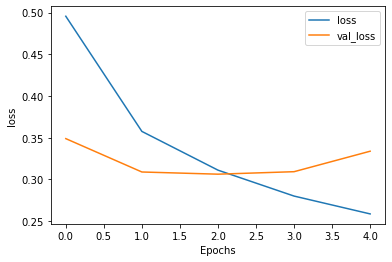

In [26]:
plot_graphs(history, 'loss')

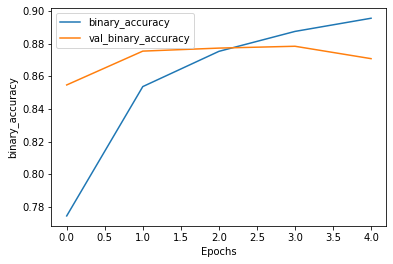

In [27]:
plot_graphs(history, 'binary_accuracy')

#### Evaluating the outcome of a single prediction

In [28]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

In [29]:
tweet_no = 4

text_test = [train_df['Tweet'][tweet_no]]

preds = classifier_model.predict([text_test])
print(text_test)

pred_dict = {}
for emotion, value in zip(emotions, preds.round()[0]):
    pred_dict[emotion] = value
    
print(pred_dict)
train_df.loc[tweet_no:tweet_no, emotions]

['my roommate its okay that we cant spell because we have autocorrect terrible firstworldprobs']
{'anger': 1.0, 'anticipation': 0.0, 'disgust': 1.0, 'fear': 0.0, 'joy': 0.0, 'love': 0.0, 'optimism': 0.0, 'pessimism': 0.0, 'sadness': 1.0, 'surprise': 0.0, 'trust': 0.0}


,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
4,1,0,1,0,0,0,0,0,0,0,0


#### Evaluating classification performance

In [30]:
preds = classifier_model.predict(train_df['Tweet'])

In [31]:
preds = pd.DataFrame(data = preds, columns = emotions)

In [32]:
preds = preds.round()

In [33]:
from sklearn.metrics import accuracy_score, f1_score

accuracies = []
f1_scores = []

for emotion in emotions:
    acc = accuracy_score(train_df[emotion], preds[emotion])
    accuracies.append(acc)
    f1score = f1_score(train_df[emotion], preds[emotion])
    f1_scores.append(f1score)
    print(f"{emotion} \nsupport: {sum(train_df[emotion])} \nAccuracy: {acc} \nF1 Score: {f1score}\n")

anger 
support: 2544 
Accuracy: 0.9365311494589061 
F1 Score: 0.9159891598915988

anticipation 
support: 978 
Accuracy: 0.8739397484644633 
F1 Score: 0.242530755711775

disgust 
support: 2602 
Accuracy: 0.9004094764551038 
F1 Score: 0.8754344247301994

fear 
support: 1242 
Accuracy: 0.941649605147704 
F1 Score: 0.8129395218002812

joy 
support: 2477 
Accuracy: 0.9292190699034806 
F1 Score: 0.8949196699956579

love 
support: 700 
Accuracy: 0.9436969874232232 
F1 Score: 0.6717817561807331

optimism 
support: 1984 
Accuracy: 0.8955835039485229 
F1 Score: 0.8117088607594938

pessimism 
support: 795 
Accuracy: 0.9027493419128401 
F1 Score: 0.5077720207253886

sadness 
support: 2008 
Accuracy: 0.8812518280198889 
F1 Score: 0.8046198267564966

surprise 
support: 361 
Accuracy: 0.9492541678853466 
F1 Score: 0.07466666666666666

trust 
support: 357 
Accuracy: 0.9483767183386955 
F1 Score: 0.03814713896457765



In [34]:
# Macro Scores

np.mean(accuracies), np.mean(f1score)

(0.918423781541652, 0.03814713896457765)

In [35]:
test_df.loc[test_df['surprise']==1]['Tweet'].to_list()

['ano man im stunned! at one point our heads were gone and they were scoring at will! relieved',
 'this one? na bit odd looking isnt he? pointy the alien asked nperhaps but hell be wonderful hes from the steve pile vss',
 'placed order for nearly a grand six weeks ago called yesterday order missing and no call back today! shocking',
 'i didnt ask for this either it just happened face with steam from nose',
 'why is everybody seem sp serious?',
 'can it do the bell ringing and incense at consecration?',
 'what a shake down operation!',
 'hi! im curious as to what happened to your growing space in crouch end? is it just empty?!',
 'you guys sound astounded!! does anyone working w trump wh have an any ethical moral values? see no evil monkey hear no evil monkey speak no evil monkey',
 'cant believe zain starting secondary this year crying face',
 'absolutely shocking behavour!!!!!!',
 'when you only meet each other once at an interview and you recognise each other on the streets person ge

In [36]:
test_preds = classifier_model.predict(test_df['Tweet'])
test_preds = pd.DataFrame(data = test_preds, columns = emotions)
test_preds = test_preds.round()

In [37]:
len(test_preds)

886

In [38]:
test_accuracies = []
f1_scores_test = []

for emotion in emotions:
    acc = accuracy_score(test_df[emotion], test_preds[emotion])
    test_accuracies.append(acc)
    f1score = f1_score(test_df[emotion], test_preds[emotion])
    f1_scores_test.append(f1score)
    print(f"{emotion} \nsupport: {sum(test_df[emotion])} \nAccuracy: {acc} \nF1 Score: {f1score}\n")

anger 
support: 315 
Accuracy: 0.835214446952596 
F1 Score: 0.7704402515723272

anticipation 
support: 124 
Accuracy: 0.8656884875846501 
F1 Score: 0.07751937984496124

disgust 
support: 319 
Accuracy: 0.8250564334085779 
F1 Score: 0.7696879643387816

fear 
support: 121 
Accuracy: 0.9311512415349887 
F1 Score: 0.7264573991031389

joy 
support: 400 
Accuracy: 0.8363431151241535 
F1 Score: 0.7931526390870186

love 
support: 132 
Accuracy: 0.891647855530474 
F1 Score: 0.5932203389830509

optimism 
support: 307 
Accuracy: 0.8115124153498872 
F1 Score: 0.701252236135957

pessimism 
support: 100 
Accuracy: 0.8724604966139955 
F1 Score: 0.3615819209039548

sadness 
support: 265 
Accuracy: 0.7979683972911964 
F1 Score: 0.6940170940170941

surprise 
support: 35 
Accuracy: 0.9627539503386005 
F1 Score: 0.1081081081081081

trust 
support: 43 
Accuracy: 0.9503386004514672 
F1 Score: 0.0



In [39]:
# Macro Test Scores

np.mean(test_accuracies), np.mean(f1_scores_test)

(0.8709214036527805, 0.5086761210994902)

#### Attempting classification using augmented and re-classified dataset by LLM

In [64]:
new_data = pd.read_csv('datasets/E-c-En-Reclassified.csv')

In [65]:
X = new_data['Tweet'] 
y = new_data.loc[:,['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
       'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,         # 20% test, 80% train
    random_state=42,       # for reproducibility 
)

In [67]:
X_train.shape, X_test.shape

((6488,), (1623,))

In [71]:
tf.keras.backend.clear_session()

classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [72]:
epochs = 5
batch_size = 32

In [73]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score 

class MultiLabelF1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        val_x, val_y = self.validation_data

        # Run inference in "no_grad" mode to speed it up
        y_pred = self.model.predict(val_x, verbose=0)
        y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

        # Compute F1-score for multi-label classification
        f1 = f1_score(val_y, y_pred, average="samples", zero_division=1)  # "samples" is best for multi-label tasks

        logs["val_f1_score"] = f1
#         print(f" — val_f1_score: {f1:.4f}")

# Train model with optimized callback
f1_callback = MultiLabelF1ScoreCallback(validation_data=(test_x, test_y))

history = classifier_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[f1_callback]
)

Epoch 1/5
203/203 [==============================] - 72s 329ms/step - loss: 0.2429 - binary_accuracy: 0.9066 - val_loss: 0.1993 - val_binary_accuracy: 0.9191 - val_f1_score: 0.5113
Epoch 2/5
203/203 [==============================] - 66s 325ms/step - loss: 0.2027 - binary_accuracy: 0.9233 - val_loss: 0.1954 - val_binary_accuracy: 0.9206 - val_f1_score: 0.5337
Epoch 3/5
203/203 [==============================] - 66s 325ms/step - loss: 0.1623 - binary_accuracy: 0.9393 - val_loss: 0.1929 - val_binary_accuracy: 0.9244 - val_f1_score: 0.5240
Epoch 4/5
203/203 [==============================] - 66s 325ms/step - loss: 0.1330 - binary_accuracy: 0.9509 - val_loss: 0.2061 - val_binary_accuracy: 0.9268 - val_f1_score: 0.5346
Epoch 5/5
203/203 [==============================] - 66s 324ms/step - loss: 0.1059 - binary_accuracy: 0.9613 - val_loss: 0.2282 - val_binary_accuracy: 0.9218 - val_f1_score: 0.5518


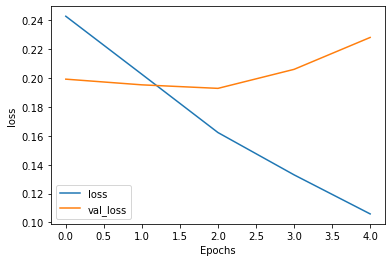

In [74]:
plot_graphs(history, 'loss')

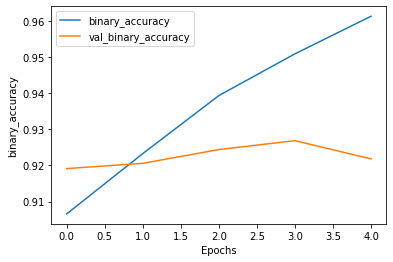

In [76]:
plot_graphs(history, 'binary_accuracy')

In [77]:
preds = classifier_model.predict(X_train)

In [78]:
preds = pd.DataFrame(data = preds, columns = emotions)

In [84]:
y_train_df = pd.DataFrame(data = y_train, columns = emotions)

In [79]:
preds = preds.round()

In [86]:
from sklearn.metrics import accuracy_score, f1_score

accuracies = []
f1_scores = []

for emotion in emotions:
    acc = accuracy_score(y_train_df[emotion], preds[emotion])
    accuracies.append(acc)
    f1score = f1_score(y_train_df[emotion], preds[emotion])
    f1_scores.append(f1score)
    print(f"{emotion} \nsupport: {sum(y_train_df[emotion])} \nAccuracy: {acc} \nF1 Score: {f1score}\n")

anger 
support: 1554 
Accuracy: 0.9847410604192355 
F1 Score: 0.9682386910490857

anticipation 
support: 302 
Accuracy: 0.9856658446362515 
F1 Score: 0.8353982300884956

disgust 
support: 1002 
Accuracy: 0.9796547472256474 
F1 Score: 0.9345238095238095

fear 
support: 714 
Accuracy: 0.9896732429099877 
F1 Score: 0.9529163738580463

joy 
support: 2130 
Accuracy: 0.9813501849568435 
F1 Score: 0.9717751341264287

love 
support: 306 
Accuracy: 0.9953760789149199 
F1 Score: 0.9498327759197325

optimism 
support: 550 
Accuracy: 0.9815043156596794 
F1 Score: 0.8926654740608229

pessimism 
support: 259 
Accuracy: 0.9859741060419236 
F1 Score: 0.8253358925143953

sadness 
support: 1932 
Accuracy: 0.9779593094944513 
F1 Score: 0.9624178712220762

surprise 
support: 310 
Accuracy: 0.9864364981504316 
F1 Score: 0.8503401360544217

trust 
support: 366 
Accuracy: 0.9836621454993835 
F1 Score: 0.8354037267080746



In [87]:
# Macro Scores

np.mean(accuracies), np.mean(f1score)

(0.9847270485371596, 0.8354037267080746)

In [88]:
test_preds = classifier_model.predict(X_test)
test_preds = pd.DataFrame(data = test_preds, columns = emotions)
test_preds = test_preds.round()
y_test_df = pd.DataFrame(data = y_test, columns = emotions)

In [89]:
test_accuracies = []
f1_scores_test = []

for emotion in emotions:
    acc = accuracy_score(y_test_df[emotion], test_preds[emotion])
    test_accuracies.append(acc)
    f1score = f1_score(y_test_df[emotion], test_preds[emotion])
    f1_scores_test.append(f1score)
    print(f"{emotion} \nsupport: {sum(y_test_df[emotion])} \nAccuracy: {acc} \nF1 Score: {f1score}\n")

anger 
support: 372 
Accuracy: 0.8841651263093038 
F1 Score: 0.758974358974359

anticipation 
support: 93 
Accuracy: 0.9531731361675909 
F1 Score: 0.5189873417721519

disgust 
support: 244 
Accuracy: 0.8897104128157732 
F1 Score: 0.6383838383838384

fear 
support: 176 
Accuracy: 0.9303758471965496 
F1 Score: 0.6904109589041096

joy 
support: 511 
Accuracy: 0.8582871226124461 
F1 Score: 0.7821969696969697

love 
support: 76 
Accuracy: 0.9704251386321626 
F1 Score: 0.6190476190476191

optimism 
support: 145 
Accuracy: 0.9328404189772027 
F1 Score: 0.6305084745762712

pessimism 
support: 58 
Accuracy: 0.9716574245224893 
F1 Score: 0.5964912280701754

sadness 
support: 500 
Accuracy: 0.8404189772027111 
F1 Score: 0.7310488058151609

surprise 
support: 69 
Accuracy: 0.9630314232902033 
F1 Score: 0.5384615384615384

trust 
support: 95 
Accuracy: 0.9457794208256316 
F1 Score: 0.3802816901408451



In [90]:
# Macro Test Scores

np.mean(test_accuracies), np.mean(f1_scores_test)

(0.9218058589592787, 0.6258902567130035)

In [91]:
text_test = 'dirty chai tea with rumchata hits the spot on this gloomy tuesday morning smiling face with smiling eyes'

preds = classifier_model.predict([text_test])
print(text_test)

pred_dict = {}
for emotion, value in zip(emotions, preds.round()[0]):
    pred_dict[emotion] = value
    
print(pred_dict) 

dirty chai tea with rumchata hits the spot on this gloomy tuesday morning smiling face with smiling eyes
{'anger': 0.0, 'anticipation': 0.0, 'disgust': 0.0, 'fear': 0.0, 'joy': 1.0, 'love': 0.0, 'optimism': 0.0, 'pessimism': 0.0, 'sadness': 0.0, 'surprise': 0.0, 'trust': 0.0}


In [92]:
text_test = 'you guys sound astounded!! does anyone working w trump wh have an any ethical moral values? see no evil monkey hear no evil monkey speak no evil monkey'

preds = classifier_model.predict([text_test])
print(text_test)

pred_dict = {}
for emotion, value in zip(emotions, preds.round()[0]):
    pred_dict[emotion] = value
    
print(pred_dict) 

you guys sound astounded!! does anyone working w trump wh have an any ethical moral values? see no evil monkey hear no evil monkey speak no evil monkey
{'anger': 0.0, 'anticipation': 0.0, 'disgust': 1.0, 'fear': 0.0, 'joy': 0.0, 'love': 0.0, 'optimism': 0.0, 'pessimism': 0.0, 'sadness': 0.0, 'surprise': 1.0, 'trust': 0.0}


In [93]:
text_test = 'this casino is amazing I have won so much money!'

preds = classifier_model.predict([text_test])
print(text_test)

pred_dict = {}
for emotion, value in zip(emotions, preds.round()[0]):
    pred_dict[emotion] = value
    
print(pred_dict) 

this casino is amazing I have won so much money!
{'anger': 0.0, 'anticipation': 0.0, 'disgust': 0.0, 'fear': 0.0, 'joy': 1.0, 'love': 0.0, 'optimism': 0.0, 'pessimism': 0.0, 'sadness': 0.0, 'surprise': 0.0, 'trust': 0.0}


In [95]:
text_test = 'i went to the mall and a person cut me off in line'

preds = classifier_model.predict([text_test])
print(text_test)

pred_dict = {}
for emotion, value in zip(emotions, preds.round()[0]):
    pred_dict[emotion] = value
    
print(pred_dict) 

i went to the mall and a person cut me off in line
{'anger': 1.0, 'anticipation': 0.0, 'disgust': 0.0, 'fear': 0.0, 'joy': 0.0, 'love': 0.0, 'optimism': 0.0, 'pessimism': 0.0, 'sadness': 1.0, 'surprise': 0.0, 'trust': 0.0}
